In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
import pandas as pd

df = pd.read_csv('./2024-datalab-cup1/train.csv')
print(df.head(5))

   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


In [3]:
print(df.loc[0,'Page content'])

<html><head><div class="article-info"> <span class="byline basic">Clara Moskowitz</span> for <a href="/publishers/space-com/">Space.com</a> <time datetime="Wed, 19 Jun 2013 15:04:30 +0000">2013-06-19 15:04:30 UTC</time> </div></head><body><h1 class="title">NASA's Grand Challenge: Stop Asteroids From Destroying Earth</h1><figure class="article-image"><img class="microcontent" data-fragment="lead-image" data-image="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg" data-micro="1" data-url="http://mashable.com/2013/06/19/nasa-grand-challenge-asteroid/" src="http://i.amz.mshcdn.com/I7b9cUsPSztew7r1WT6_iBLjflo=/950x534/2013%2F06%2F19%2Ffe%2FDactyl.44419.jpg"/></figure><article data-channel="world"><section class="article-content"> <p>There may be killer asteroids headed for Earth, and NASA has decided to do something about it. The space agency announced a new "Grand Challenge" on June 18 to find all dangerous space rocks and figure out how t

In [4]:
X_train = df['Page content']
y_train = df['Popularity']

In [5]:
import re
from bs4 import BeautifulSoup

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

In [6]:
print(preprocessor(df.loc[0,'Page content']))

 clara moskowitz for space com 2013 06 19 15 04 30 utc nasa s grand challenge stop asteroids from destroying earth there may be killer asteroids headed for earth and nasa has decided to do something about it the space agency announced a new grand challenge on june 18 to find all dangerous space rocks and figure out how to stop them from destroying our planet the new mission builds on projects already underway at nasa including a plan to capture an asteroid pull it in toward the moon and send astronauts to visit it as part of the grand challenge the agency issued a request for information today aiming to solicit ideas from industry academia and the public on how to improve the asteroid mission plan we re asking for you to think about concepts and different approaches for what we ve described here william gerstenmaier nasa s associate administrator for human explorations and operations said yesterday during a nasa event announcing the initiative we want you to think about other ways of e

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop = stopwords.words('english')

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
print(tokenizer_stem_nostop('runners like running and thus they run'))

['runner', 'like', 'run', 'thu', 'run']


In [9]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def feature_extraction(df, batch_size):
    content = df['Page content']
    if content.shape[0] < batch_size:
        batch_size = content.shape[0]
    pics = []
    links = []
    #time = []
    for i in range(batch_size):
        soup = BeautifulSoup(content.iloc[i],'html.parser')
        # count number of pictures in html
        pics.append(len(soup.find_all('img')))
        # count number of links in html
        links.append(len(soup.find_all('a')))
        #time.append(soup.find('time')['datetime'])
    
    # normalize pics and links
    pics = StandardScaler().fit_transform(np.array(pics).reshape(-1,1))
    links = StandardScaler().fit_transform(np.array(links).reshape(-1,1))
    
    # append to batch
    df['n_pics'] = pics
    df['n_links'] = links
    return df

In [10]:
def get_stream(path, size):
    for chunk in pd.read_csv(path, chunksize=size):
        # perform feature extraction for each chunk
        yield feature_extraction(chunk, size)

print(next(get_stream(path='./2024-datalab-cup1/train.csv', size=10)))

   Id  Popularity                                       Page content  \
0   0          -1  <html><head><div class="article-info"> <span c...   
1   1           1  <html><head><div class="article-info"><span cl...   
2   2           1  <html><head><div class="article-info"><span cl...   
3   3          -1  <html><head><div class="article-info"><span cl...   
4   4          -1  <html><head><div class="article-info"><span cl...   
5   5          -1  <html><head><div class="article-info"> <span c...   
6   6           1  <html><head><div class="article-info"><span cl...   
7   7          -1  <html><head><div class="article-info"><span cl...   
8   8           1  <html><head><div class="article-info"><span cl...   
9   9          -1  <html><head><div class="article-info"><span cl...   

     n_pics   n_links  
0 -0.362462  1.048071  
1 -0.296560  0.337515  
2 -0.296560 -0.905960  
3 -0.362462 -0.550682  
4  2.998552 -0.017764  
5 -0.362462  2.469185  
6 -0.362462 -0.905960  
7 -0.296560 -0.

In [11]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

In [12]:
hashvec = HashingVectorizer(n_features=2**10,
                            preprocessor=preprocessor, tokenizer=tokenizer_stem_nostop)
# loss='log' gives logistic regression
clf = SGDClassifier(loss='log_loss', max_iter=100, tol=1e-3)
batch_size = 1000
stream = get_stream(path='./2024-datalab-cup1/train.csv', size=batch_size)
classes = np.array([-1, 1])
data_size = df.shape[0]
train_auc, val_auc = [], []
# we use one batch for training and another for validation in each iteration
iters = int((data_size+batch_size-1)/(batch_size*2))
for i in range(iters):
    batch = next(stream)
    X_train, y_train = batch['Page content'], batch['Popularity']
    if X_train is None:
        break
    X_train = hashvec.transform(X_train)
    # append n_pics and n_links to features
    X_train = sp.sparse.hstack((X_train, sp.sparse.csr_matrix(batch[['n_pics', 'n_links']].values)))
    clf.partial_fit(X_train, y_train, classes=classes)
    train_auc.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))

    # validate
    batch = next(stream)
    X_val, y_val = batch['Page content'], batch['Popularity']
    X_val = hashvec.transform(X_val)
    # append n_pics and n_links to X_val
    X_val = sp.sparse.hstack((X_val, sp.sparse.csr_matrix(batch[['n_pics', 'n_links']].values)))
    score = roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])
    val_auc.append(score)
    print('[{}/{}] {}'.format((i+1)*(batch_size*2), data_size, score))

[2000/27643] 0.5271352740548589
[4000/27643] 0.48408432242625393
[6000/27643] 0.5333561334245337
[8000/27643] 0.5353723744877049
[10000/27643] 0.5218106663978224
[12000/27643] 0.5188186774723891
[14000/27643] 0.47634233491651296
[16000/27643] 0.487109535943294
[18000/27643] 0.4738968837892227
[20000/27643] 0.5026232483113218
[22000/27643] 0.5300693199282787
[24000/27643] 0.5629290068641097
[26000/27643] 0.5405821623286493
[28000/27643] 0.4860366549902266


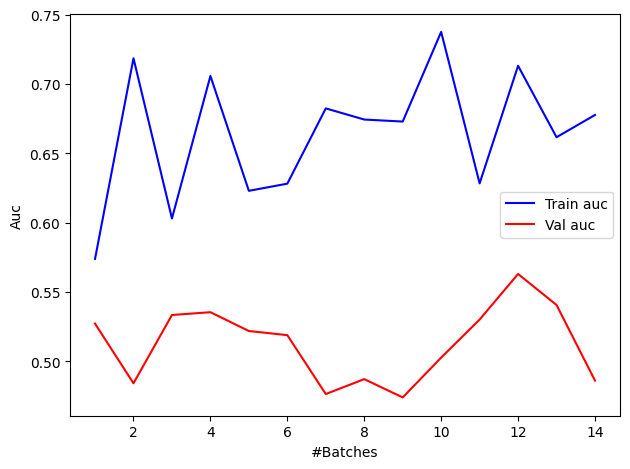

In [13]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/fig-out-of-core.png', dpi=300)
plt.show()

In [18]:
batch_size = 1000
stream = get_stream(path='./2024-datalab-cup1/test.csv', size=batch_size)
df = pd.read_csv('./2024-datalab-cup1/test.csv')
data_size = df.shape[0]
print(data_size)
results = []
# we use one batch for training and another for validation in each iteration
iters = int((data_size+batch_size-1)/(batch_size))
for i in range(iters):
    batch = next(stream)
    X_test = batch['Page content']
    if X_test is None:
        break
    X_test = hashvec.transform(X_test)
    X_test = sp.sparse.hstack((X_test, sp.sparse.csr_matrix(batch[['n_pics', 'n_links']].values)))
    # get the probability of the positive class
    y_test = clf.predict_proba(X_test)[:,1]
    results.extend(zip(batch['Id'], y_test))
    print('[{}/{}]'.format((i+1)*(batch_size), data_size))

results_df = pd.DataFrame(results, columns=['Id', 'Popularity'])
print(results_df.shape)

# Save the DataFrame to a CSV file
results_df.to_csv('predictions.csv', index=False)
    

11847
[1000/11847]
[2000/11847]
[3000/11847]
[4000/11847]
[5000/11847]
[6000/11847]
[7000/11847]
[8000/11847]
[9000/11847]
[10000/11847]
[11000/11847]
[12000/11847]
(11847, 2)
